In [78]:
%pylab inline
from scipy.optimize import minimize

Populating the interactive namespace from numpy and matplotlib


### Рассмотрим функция Розенброка 

$$f(x)=\sum_{i=1}^{N-1}\big[100(x_{i+1}-x_{i}^2)^2+(1-x_i)^2\big]$$

In [79]:
def rosen(x):
    """The Rosenbrock function"""
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0, axis=0)

### Визуализируем функцию Розенброка

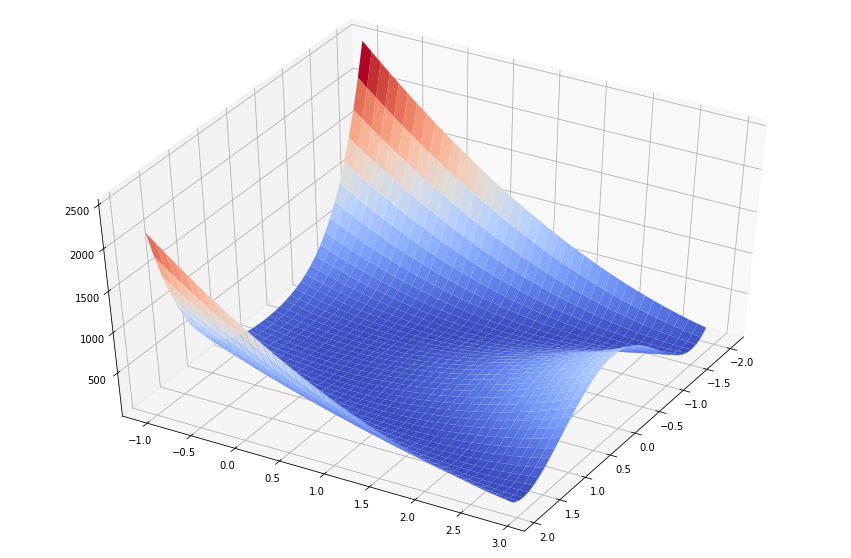

In [80]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Настраиваем 3D график
fig = plt.figure(figsize=[15, 10])
ax = fig.gca(projection='3d')

# Задаем угол обзора
ax.view_init(45, 30)

# Создаем данные для графика
X = np.arange(-2, 2, 0.1)
Y = np.arange(-1, 3, 0.1)
X, Y = np.meshgrid(X, Y)
Z = rosen(np.array([X,Y]))

# Рисуем поверхность
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.show()

### Минимум достигается при $x_i=1$ и равен 0

### Симплекс-метод Нелдера-Мида (Nelder-Mead)

Пусть имеется начальная точка x0 в 5-мерном пространстве. Найдем ближайшую к ней точку минимума функции Розенброка с помощью алгоритма симплекса Nelder-Mead (алгоритм указан в качестве значения параметра method):

In [81]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
[1. 1. 1. 1. 1.]


### Метод Пауэлла

In [82]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='powell',
    options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 1622
[1. 1. 1. 1. 1.]


### Алгоритм Бройдена-Флетчера-Голдфарба-Шанно (BFGS)

Для получения более быстрой сходимости к решению, процедура BFGS использует градиент целевой функции. Градиент может быть задан в виде функции или вычисляться с помощью разностей первого порядка. В любом случае, обычно метод BFGS требует меньше вызовов функций, чем симплекс-метод.

Найдем производную от функции Розенброка в аналитическом виде:

$$\frac{df}{dx_j}=\sum_{i=1}^N 200 (x_i-x_{i-1}^2) (\delta_{i,j}-2x_{i-1,j}) -2(1-x_{i-1})\delta_{i-1,j}=
200(x_j-x_{j-1}^2) -400x_j (x_{j+1}-x_j^2)-2(1-x_j)$$

Это выражение справедливо для производных всех переменных, кроме первой и последней, которые определяются как:

$$\frac{df}{dx_0}=-400x_0(x_1-x_0^2)-2(1-x_0),$$

$$\frac{df}{dx_{N-1}}=200(x_{N-1}-x_{N-2}^2)$$

In [83]:
def rosen_der (x):
    xm = x [1: -1]
    xm_m1 = x [: - 2]
    xm_p1 = x [2:]
    der = np.zeros_like (x)
    der [1: -1] = 200 * (xm-xm_m1 ** 2) - 400 * (xm_p1 - xm ** 2) * xm - 2 * (1-xm)
    der [0] = -400 * x [0] * (x [1] -x [0] ** 2) - 2 * (1-x [0])
    der [-1] = 200 * (x [-1] -x [-2] ** 2)
    return der

In [84]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
[1.00000004 1.0000001  1.00000021 1.00000044 1.00000092]


### Алгоритм сопряженных градиентов (Ньютона)

Алгоритм сопряженных градиентов Ньютона является модифицированным методом Ньютона.
Метод Ньютона основан на аппроксимации функции в локальной области полиномом второй степени:

$$f(x)\approx f(x_0)+\triangledown f(x_0)\cdot (x-x_0) +\frac{1}{2}(x-x_0)^T H(x_0)(x-x_0)$$

где $H(x_0)$является матрицей вторых производных (матрица Гессе, гессиан).

Гессиан функции Розенброка в аналитическом виде равен:

$$H_{i,j}=\frac{d^2 f}{dx_i x_j}=(202+1200x_i^2-400x_{i+1})\delta_{i,j}-400x_i \delta_{i+1,j}-400x_{i-1}\delta_{i-1,j}$$

где $i\in [1,N-2]$ и $j\in [0,N-1]$, определяют матрицу $NxN$.

Остальные ненулевые элементы матрицы равны:

$$\frac{d^2 f}{dx_0^2}=1200x_0^2-400x_1+2$$

$$\frac{d^2 f}{dx_0 x_1}=\frac{d^2 f}{dx_1 x_0}=-400x_0$$

$$\frac{d^2 f}{dx_{N-1}x_{N-2} }=\frac{d^2 f}{dx_{N-1}x_{N-2} }=-400x_{N-2}$$

$$\frac{d^2 f}{dx_{N-1}^2}=200$$

In [85]:
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

res = minimize(rosen, x0, method='Newton-CG', 
               jac=rosen_der, hess=rosen_hess,
               options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 24
[1.         1.         1.         0.99999999 0.99999999]


Вместо матрицы храним вектор

In [86]:
def rosen_hess_p(x, p):
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1] \
    -400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hessp=rosen_hess_p,
               options={'xtol': 1e-8, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 66


array([1.        , 1.        , 1.        , 0.99999999, 0.99999999])